# Visualisation of the priors placed on the length scales for the two families of GP test problem

In [1]:
def ensure_root_dir_on_path():
    import os
    import sys

    sources_root_path = os.path.abspath("../src")
    if sources_root_path not in sys.path:
        sys.path.append(sources_root_path)


ensure_root_dir_on_path()

In [2]:
import os

import numpy as np
import scipy.stats
import seaborn as sns
import yaml
from matplotlib import pyplot as plt

from decoupledbo.pipeline.data_catalog import DataCatalog

In [3]:
CONFIG_DIR = os.path.abspath("../config")

SAVE_PLOTS = True  # If set to true, save plots when the notebook is run
PLOTS_DIR = "./plots/"

if SAVE_PLOTS and not os.path.exists(PLOTS_DIR):
    os.mkdir(PLOTS_DIR)

In [4]:
PALETTE = sns.color_palette("colorblind")
BLUE = PALETTE[0]
DPI = 200

In [5]:
def plot_lengthscale_priors(config_fname, problem_name, fig=None):
    with open(os.path.join(CONFIG_DIR, config_fname)) as f:
        config = yaml.safe_load(f)["model"]

    test_problem_data = DataCatalog.load_shared_gp_test_problem_data(problem_name)
    true_hparams = test_problem_data["fixed_hyperparams"]

    if not fig:
        fig = plt.figure(figsize=(6, 2), dpi=DPI, constrained_layout=True)
    axs = fig.subplots(1, 2, sharex=True, sharey=True)

    n_outputs = len(config["outputs"])

    lengthscale_rvs = [None] * n_outputs
    for i in range(n_outputs):
        lengthscale_rvs[i] = _make_distribution(
            config["outputs"][i]["kernel"]["lengthscale_prior"]
        )

    max_x_lengthscale = max(rv.ppf(0.99) for rv in lengthscale_rvs)

    assert all(rv.cdf(0) == 0 for rv in lengthscale_rvs)

    x_lengthscale = np.linspace(0, max_x_lengthscale, 1000)
    y_lengthscales = [rv.pdf(x_lengthscale) for rv in lengthscale_rvs]

    for i in range(n_outputs):
        axs[i].plot(x_lengthscale, y_lengthscales[i], color=BLUE)
        axs[i].fill_between(x_lengthscale, y_lengthscales[i], color=BLUE, alpha=0.2)

    for i in range(n_outputs):
        axs[i].axvline(
            true_hparams["length_scales"][i],
            color="black",
            linestyle="dashed",
            label="True length-scale"
        )

    axs[0].set_ylabel("Probability density")
    axs[0].set_xlabel("First objective length scale")
    axs[1].set_xlabel("Second objective length scale")

    axs[-1].legend(loc="upper right")
    for ax in axs:
        ax.spines[["top", "right"]].set_visible(False)
        ax.set_ylim(bottom=0)
        ax.set_xlim(left=0)

    return fig


def _make_distribution(config):
    if config["type"] == "gamma":
        args = config["args"]
        return scipy.stats.gamma(args["concentration"], scale=1/args["rate"])
    else:
        raise ValueError(f"Unrecognised prior type: {config['type']!r}")

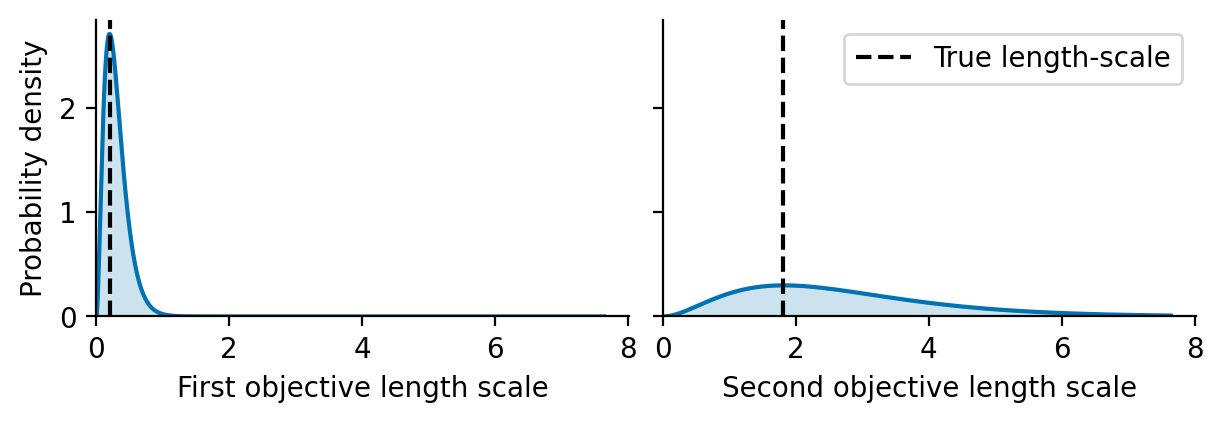

In [6]:
fig = plot_lengthscale_priors(
    config_fname="experiment-lengthscales.yaml",
    problem_name="lengthscales/0"
)
if SAVE_PLOTS:
    fname = f"lengthscale-priors--lengthscales"
    fig.savefig(os.path.join(PLOTS_DIR, f"{fname}.pdf"))
    fig.savefig(os.path.join(PLOTS_DIR, f"{fname}.png"))

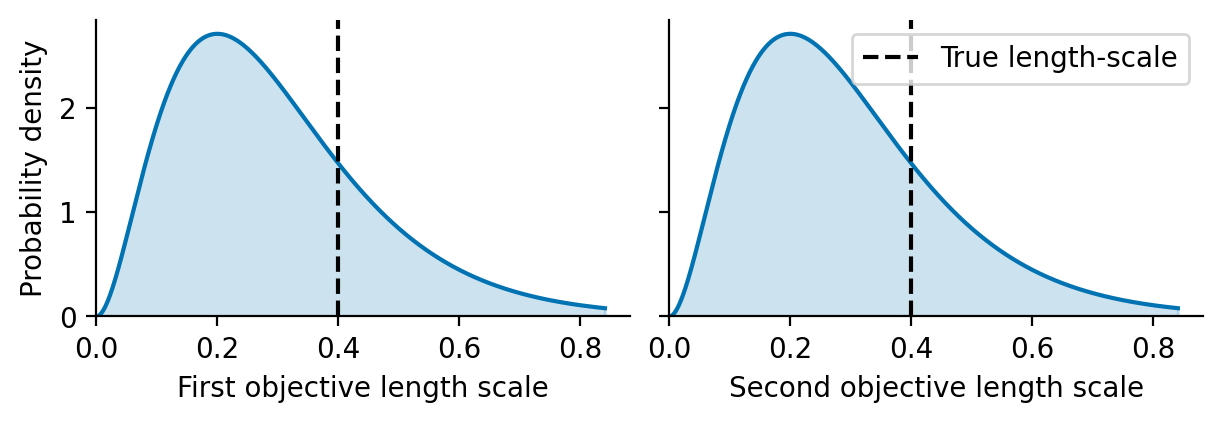

In [7]:
fig = plot_lengthscale_priors(
    config_fname="experiment-observationnoise.yaml",
    problem_name="observationnoise/0"
)
if SAVE_PLOTS:
    fname = f"lengthscale-priors--observationnoise"
    fig.savefig(os.path.join(PLOTS_DIR, f"{fname}.pdf"))
    fig.savefig(os.path.join(PLOTS_DIR, f"{fname}.png"))